In [1]:
!pip install gpflow
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import gpflow
from gpflow.ci_utils import ci_niter
from scipy.cluster.vq import kmeans2

from typing import Dict, Optional, Tuple
import tensorflow as tf
import tensorflow_datasets as tfds
import gpflow
from gpflow.utilities import to_default_float

iterations = ci_niter(100)

     |████████████████████████████████| 286 kB 18.7 MB/s 


In [26]:
original_dataset, info = tfds.load(name="mnist", split=tfds.Split.TRAIN, with_info=True)
total_num_data = info.splits["train"].num_examples
image_shape = info.features["image"].shape
image_size = tf.reduce_prod(image_shape)
batch_size = 128


def map_fn(input_slice: Dict[str, tf.Tensor]):
    updated = input_slice
    image = to_default_float(updated["image"]) / 126.0
    label = to_default_float(updated["label"])
    return tf.reshape(image, [-1, image_size]), label


autotune = tf.data.experimental.AUTOTUNE
dataset = (
    original_dataset.shuffle(1024)
    .batch(batch_size, drop_remainder=True)
    .map(map_fn, num_parallel_calls=autotune)
    .prefetch(autotune)
    .repeat()
)

In [6]:
tf.reshape([-1,image_size]

[-1, <tf.Tensor: shape=(), dtype=int32, numpy=784>]

In [27]:
class KernelWithMLP(gpflow.kernels.Kernel):
    def __init__(
        self,
        image_shape: Tuple,
        output_dim: int,
        base_kernel: gpflow.kernels.Kernel,
        batch_size: Optional[int] = None,
    ):
        super().__init__()
        with self.name_scope:
            self.base_kernel = base_kernel
            input_size = 28*28 
            #int(tf.reduce_prod(image_shape))
            input_shape = (input_size,)

            self.mlp = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=input_shape, batch_size=batch_size),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(400,activation="relu"),
                    tf.keras.layers.Dense(400,activation="relu"),
                    tf.keras.layers.Dense(output_dim, activation="relu"),
                    tf.keras.layers.Lambda(to_default_float),
                ]
            )

            self.mlp.build()

    def K(self, a_input: tf.Tensor, b_input: Optional[tf.Tensor] = None) -> tf.Tensor:
        transformed_a = self.mlp(a_input)
        transformed_b = self.mlp(b_input) if b_input is not None else b_input
        return self.base_kernel.K(transformed_a, transformed_b)

    def K_diag(self, a_input: tf.Tensor) -> tf.Tensor:
        transformed_a = self.mlp(a_input)
        return self.base_kernel.K_diag(transformed_a)

In [28]:
class KernelSpaceInducingPoints(gpflow.inducing_variables.InducingPoints):
    pass


@gpflow.covariances.Kuu.register(KernelSpaceInducingPoints, KernelWithMLP)
def Kuu(inducing_variable, kernel, jitter=None):
    func = gpflow.covariances.Kuu.dispatch(
        gpflow.inducing_variables.InducingPoints, gpflow.kernels.Kernel
    )
    return func(inducing_variable, kernel.base_kernel, jitter=jitter)


@gpflow.covariances.Kuf.register(KernelSpaceInducingPoints, KernelWithMLP, object)
def Kuf(inducing_variable, kernel, a_input):
    return kernel.base_kernel(inducing_variable.Z, kernel.mlp(a_input))

In [29]:
num_mnist_classes = 10
output_dim = 10
num_inducing_points = 100
images_subset, labels_subset = next(iter(dataset.batch(32)))
images_subset = tf.reshape(images_subset, [-1, image_size])
labels_subset = tf.reshape(labels_subset, [-1, 1])

kernel = KernelWithMLP(
    image_shape, output_dim, gpflow.kernels.SquaredExponential(), batch_size=batch_size
)

likelihood = gpflow.likelihoods.MultiClass(num_mnist_classes)

inducing_variable_kmeans = kmeans2(images_subset.numpy(), num_inducing_points, minit="points")[0]
inducing_variable_mlp = kernel.mlp(inducing_variable_kmeans)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_mlp)

model = gpflow.models.SVGP(
    kernel,
    likelihood,
    inducing_variable=inducing_variable,
    num_data=total_num_data,
    num_latent_gps=num_mnist_classes,
)

In [32]:
data_iterator = iter(dataset)
adam_opt = tf.optimizers.Adam(0.001)

training_loss = model.training_loss_closure(data_iterator)

#elbo=tf.function(model.elbo)

@tf.function
def optimization_step():
    adam_opt.minimize(training_loss, var_list=model.trainable_variables)

logf=[]
for step in range(iterations):
    optimization_step()
    if step % 10 == 0:
      elbo = -training_loss().numpy()
      logf.append(elbo)


#tensor_data =tuple(map(tf.convert_to_tensor,dataset))
#elbo(tensor_data)

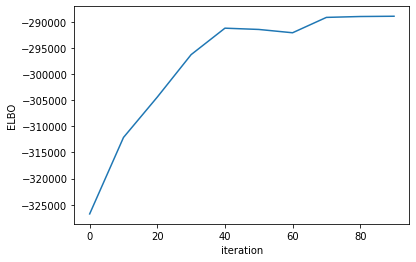

In [34]:
plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [36]:
m, v = model.predict_y(images_subset)
preds = np.argmax(m, 1).reshape(labels_subset.numpy().shape)
correct = preds == labels_subset.numpy().astype(int)
acc = np.average(correct.astype(float)) * 100.0

print("Accuracy is {:.4f}%".format(acc))

Accuracy is 96.5332%


In [23]:
dataset

<RepeatDataset shapes: ((32, 784), (32,)), types: (tf.float64, tf.float64)>